In [2]:
pip install xgboost

     |████████████████████████████████| 173.6 MB 9.6 kB/s             B 44.6 MB/s eta 0:00:03�█████████████████▉            | 107.4 MB 44.6 MB/s eta 0:00:02�███████████████████▊       | 134.2 MB 18.2 MB/s eta 0:00:03��████████████████▍  | 159.7 MB 18.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 50)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

## Defining the bucket 
s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

## Defining the csv file 
file_key_train = 'Forecasting-Flow-Traffic/train.csv'
file_key_test = 'Forecasting-Flow-Traffic/test.csv'

bucket_object_train = bucket.Object(file_key_train)
file_object_train = bucket_object_train.get()
file_content_stream_train = file_object_train.get('Body')

bucket_object_test = bucket.Object(file_key_test)
file_object_test = bucket_object_test.get()
file_content_stream_test = file_object_test.get('Body')

## Reading the csv file
train = pd.read_csv(file_content_stream_train)
test = pd.read_csv(file_content_stream_test)

## Puting time in the right format 
train['time'] = pd.to_datetime(train['time'], format = '%Y-%m-%d %H:%M:%S')
test['time'] = pd.to_datetime(test['time'], format = '%Y-%m-%d %H:%M:%S')

## Quick Distribution Comparisons

In [2]:
train.shape

(848835, 6)

In [3]:
test.shape

(2340, 5)

In [4]:
train['direction'].value_counts()

EB    156708
SB    156708
NB    156708
WB    143649
NE     91413
SW     91413
NW     26118
SE     26118
Name: direction, dtype: int64

In [5]:
test['direction'].value_counts()

NB    432
SB    432
EB    432
WB    396
NE    252
SW    252
NW     72
SE     72
Name: direction, dtype: int64

In [6]:
train['time']

0        1991-04-01 00:00:00
1        1991-04-01 00:00:00
2        1991-04-01 00:00:00
3        1991-04-01 00:00:00
4        1991-04-01 00:00:00
                 ...        
848830   1991-09-30 11:40:00
848831   1991-09-30 11:40:00
848832   1991-09-30 11:40:00
848833   1991-09-30 11:40:00
848834   1991-09-30 11:40:00
Name: time, Length: 848835, dtype: datetime64[ns]

In [7]:
test['time']

0      1991-09-30 12:00:00
1      1991-09-30 12:00:00
2      1991-09-30 12:00:00
3      1991-09-30 12:00:00
4      1991-09-30 12:00:00
               ...        
2335   1991-09-30 23:40:00
2336   1991-09-30 23:40:00
2337   1991-09-30 23:40:00
2338   1991-09-30 23:40:00
2339   1991-09-30 23:40:00
Name: time, Length: 2340, dtype: datetime64[ns]

## Engineering Basic Features

In [2]:
## Extracting day, hour and minute
train['day'] = train['time'].dt.dayofweek
train['hour'] = train['time'].dt.hour
train['minute'] = train['time'].dt.minute

test['day'] = test['time'].dt.dayofweek
test['hour'] = test['time'].dt.hour
test['minute'] = test['time'].dt.minute

## Changing direction to dummies
train = pd.concat([train, pd.get_dummies(train['direction'])], axis = 1)
test = pd.concat([test, pd.get_dummies(test['direction'])], axis = 1)

In [9]:
train.head()

,row_id,time,x,y,direction,congestion,day,hour,minute,EB,NB,NE,NW,SB,SE,SW,WB
0,0,1991-04-01,0,0,EB,70,0,0,0,1,0,0,0,0,0,0,0
1,1,1991-04-01,0,0,NB,49,0,0,0,0,1,0,0,0,0,0,0
2,2,1991-04-01,0,0,SB,24,0,0,0,0,0,0,0,1,0,0,0
3,3,1991-04-01,0,1,EB,18,0,0,0,1,0,0,0,0,0,0,0
4,4,1991-04-01,0,1,NB,60,0,0,0,0,1,0,0,0,0,0,0


In [10]:
test.head()

,row_id,time,x,y,direction,day,hour,minute,EB,NB,NE,NW,SB,SE,SW,WB
0,848835.0,1991-09-30 12:00:00,0.0,0.0,EB,0.0,12.0,0.0,1,0,0,0,0,0,0,0
1,848836.0,1991-09-30 12:00:00,0.0,0.0,NB,0.0,12.0,0.0,0,1,0,0,0,0,0,0
2,848837.0,1991-09-30 12:00:00,0.0,0.0,SB,0.0,12.0,0.0,0,0,0,0,1,0,0,0
3,848838.0,1991-09-30 12:00:00,0.0,1.0,EB,0.0,12.0,0.0,1,0,0,0,0,0,0,0
4,848839.0,1991-09-30 12:00:00,0.0,1.0,NB,0.0,12.0,0.0,0,1,0,0,0,0,0,0


## Basic Visualizations

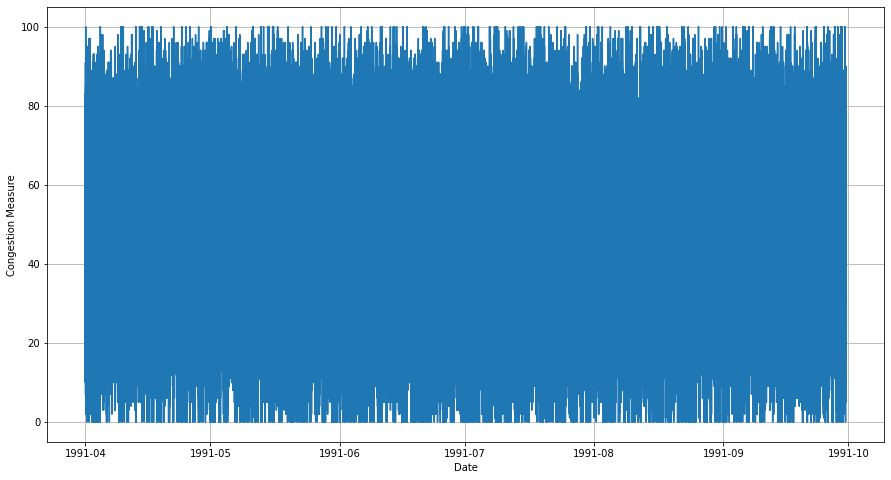

In [11]:
## Creating a new figure
plt.figure(figsize = (15, 8))

plt.plot(train['time'], train['congestion'])
plt.xlabel('Date')
plt.ylabel('Congestion Measure')
plt.grid()
plt.show()

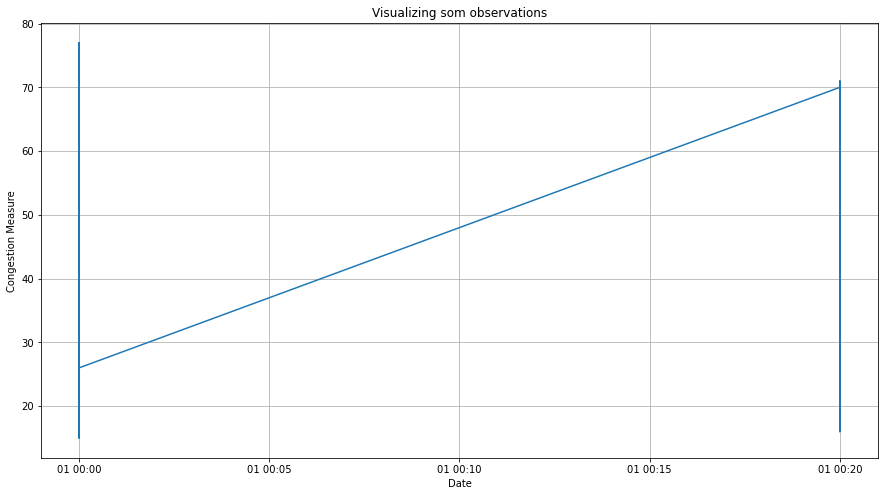

In [14]:
## Creating a new figure
plt.figure(figsize = (15, 8))

plt.plot(train['time'][0:100], train['congestion'][0:100])
plt.xlabel('Date')
plt.ylabel('Congestion Measure')
plt.title('Visualizing som observations')
plt.grid()
plt.show()

In [23]:
out = train[(train['direction'] == 'EB') & (train['x'] == 0) & (train['y'] == 0)]
out.head(10)

,row_id,time,x,y,direction,congestion,day,hour,minute,EB,NB,NE,NW,SB,SE,SW,WB
0,0,1991-04-01 00:00:00,0,0,EB,70,0,0,0,1,0,0,0,0,0,0,0
65,65,1991-04-01 00:20:00,0,0,EB,70,0,0,20,1,0,0,0,0,0,0,0
130,130,1991-04-01 00:40:00,0,0,EB,70,0,0,40,1,0,0,0,0,0,0,0
195,195,1991-04-01 01:00:00,0,0,EB,70,0,1,0,1,0,0,0,0,0,0,0
260,260,1991-04-01 01:20:00,0,0,EB,70,0,1,20,1,0,0,0,0,0,0,0
325,325,1991-04-01 01:40:00,0,0,EB,70,0,1,40,1,0,0,0,0,0,0,0
390,390,1991-04-01 02:00:00,0,0,EB,70,0,2,0,1,0,0,0,0,0,0,0
455,455,1991-04-01 02:20:00,0,0,EB,70,0,2,20,1,0,0,0,0,0,0,0
520,520,1991-04-01 02:40:00,0,0,EB,70,0,2,40,1,0,0,0,0,0,0,0
585,585,1991-04-01 03:00:00,0,0,EB,70,0,3,0,1,0,0,0,0,0,0,0


In [26]:
out.shape

(13059, 17)

In [27]:
out_test = test[(test['direction'] == 'EB') & (test['x'] == 0) & (train['y'] == 0)]
out_test.head(10)

,row_id,time,x,y,direction,day,hour,minute,EB,NB,NE,NW,SB,SE,SW,WB
0,848835.0,1991-09-30 12:00:00,0.0,0.0,EB,0.0,12.0,0.0,1,0,0,0,0,0,0,0
65,848900.0,1991-09-30 12:20:00,0.0,0.0,EB,0.0,12.0,20.0,1,0,0,0,0,0,0,0
130,848965.0,1991-09-30 12:40:00,0.0,0.0,EB,0.0,12.0,40.0,1,0,0,0,0,0,0,0
195,849030.0,1991-09-30 13:00:00,0.0,0.0,EB,0.0,13.0,0.0,1,0,0,0,0,0,0,0
260,849095.0,1991-09-30 13:20:00,0.0,0.0,EB,0.0,13.0,20.0,1,0,0,0,0,0,0,0
325,849160.0,1991-09-30 13:40:00,0.0,0.0,EB,0.0,13.0,40.0,1,0,0,0,0,0,0,0
390,849225.0,1991-09-30 14:00:00,0.0,0.0,EB,0.0,14.0,0.0,1,0,0,0,0,0,0,0
455,849290.0,1991-09-30 14:20:00,0.0,0.0,EB,0.0,14.0,20.0,1,0,0,0,0,0,0,0
520,849355.0,1991-09-30 14:40:00,0.0,0.0,EB,0.0,14.0,40.0,1,0,0,0,0,0,0,0
585,849420.0,1991-09-30 15:00:00,0.0,0.0,EB,0.0,15.0,0.0,1,0,0,0,0,0,0,0


In [28]:
out_test.shape

(36, 16)

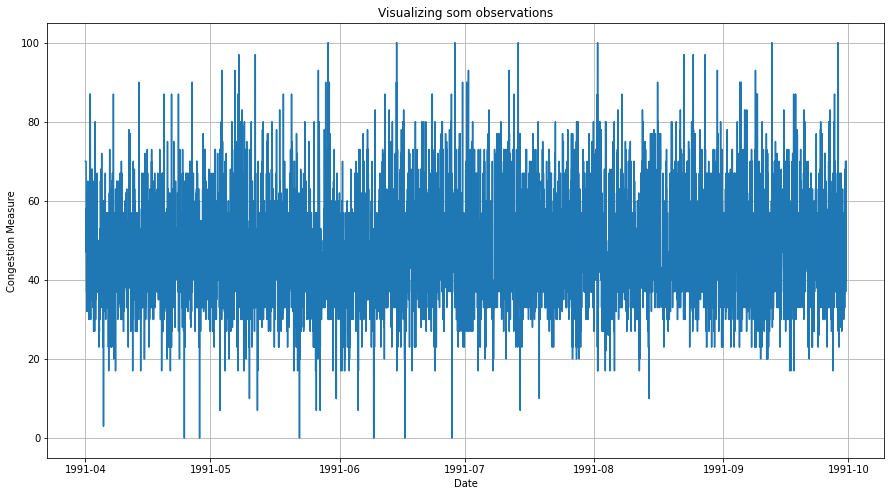

In [25]:
## Creating a new figure
plt.figure(figsize = (15, 8))

plt.plot(out['time'], out['congestion'])
plt.xlabel('Date')
plt.ylabel('Congestion Measure')
plt.title('Visualizing som observations')
plt.grid()
plt.show()

## Modeling 

In [7]:
train_data_sample = train[(train['direction'] == 'WB') & (train['x'] == 0) & (train['y'] == 0)].reset_index(drop = True)
test_data_sample = test[(test['direction'] == 'WB') & (test['x'] == 0) & (test['y'] == 0)].reset_index(drop = True)

In [15]:
train_data_sample.shape[0]

0

In [8]:
## Splitting the data intro train & valudation 
X_train = train_data_sample.loc[0:13023, ['day', 'hour', 'minute']].reset_index(drop = True)
Y_train = train_data_sample.loc[0:13023, ['congestion']].reset_index(drop = True)

X_val = train_data_sample.loc[13023:13059, ['day', 'hour', 'minute']].reset_index(drop = True)
Y_val = train_data_sample.loc[13023:13059, ['congestion']].reset_index(drop = True)

In [12]:
A = train[(train['direction'] == 'WB')]
A.shape

(143649, 17)

In [13]:
A['x'].value_counts()

2    52236
1    52236
0    39177
Name: x, dtype: int64

In [14]:
A['y'].value_counts()

3    39177
2    39177
1    39177
0    26118
Name: y, dtype: int64

In [9]:
## Buidling XGBoost
xgb = XGBRegressor(booster = 'gbtree', objective = 'reg:squarederror', n_estimators = 500, max_depth = 7, learning_rate = 0.01, n_jobs = -1).fit(X_train, Y_train)

## Predicting on the test 
xgb_pred = xgb.predict(X_val)

## Computing the mse
print(mean_squared_error(Y_val, xgb_pred))

173.4361566491336


In [32]:
data_out = train_data_sample.loc[13023:13059].reset_index(drop = True)
data_out['congestion_pred'] = xgb_pred
# data_out.loc[:, ['congestion_pred']] = xgb_pred
data_out

,row_id,time,x,y,direction,congestion,day,hour,minute,EB,NB,NE,NW,SB,SE,SW,WB,congestion_pred
0,846495,1991-09-30 00:00:00,0,0,EB,33,0,0,0,1,0,0,0,0,0,0,0,39.418079
1,846560,1991-09-30 00:20:00,0,0,EB,33,0,0,20,1,0,0,0,0,0,0,0,39.508057
2,846625,1991-09-30 00:40:00,0,0,EB,33,0,0,40,1,0,0,0,0,0,0,0,39.508877
3,846690,1991-09-30 01:00:00,0,0,EB,33,0,1,0,1,0,0,0,0,0,0,0,39.477806
4,846755,1991-09-30 01:20:00,0,0,EB,33,0,1,20,1,0,0,0,0,0,0,0,39.498314
5,846820,1991-09-30 01:40:00,0,0,EB,33,0,1,40,1,0,0,0,0,0,0,0,47.815224
6,846885,1991-09-30 02:00:00,0,0,EB,33,0,2,0,1,0,0,0,0,0,0,0,54.622437
7,846950,1991-09-30 02:20:00,0,0,EB,33,0,2,20,1,0,0,0,0,0,0,0,54.652321
8,847015,1991-09-30 02:40:00,0,0,EB,33,0,2,40,1,0,0,0,0,0,0,0,53.962894
9,847080,1991-09-30 03:00:00,0,0,EB,33,0,3,0,1,0,0,0,0,0,0,0,54.610695


In [9]:
xgb_pred

array([39.41808 , 39.508057, 39.508877, 39.477806, 39.498314, 47.815224,
       54.622437, 54.65232 , 53.962894, 54.610695, 54.58254 , 53.799004,
       54.1152  , 52.251247, 48.11481 , 52.579212, 46.347187, 46.62214 ,
       51.83403 , 45.63191 , 47.064217, 45.25699 , 44.740257, 47.372375,
       48.055504, 46.154934, 48.104294, 48.83319 , 49.27556 , 51.495968,
       48.169716, 49.838062, 52.723694, 47.651947, 48.3992  , 52.290684],
      dtype=float32)

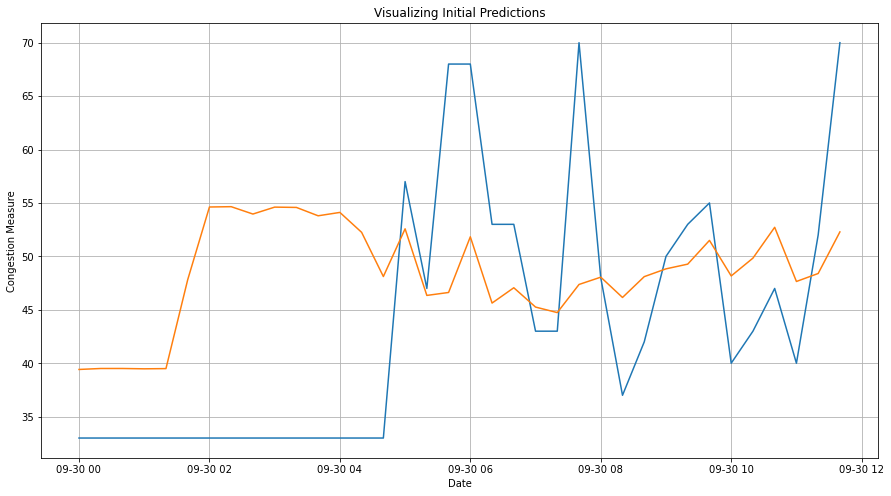

In [10]:
## Creating a new figure
plt.figure(figsize = (15, 8))

plt.plot(train_data_sample['time'][13023:13059], train_data_sample['congestion'][13023:13059])
plt.plot(train_data_sample['time'][13023:13059], xgb_pred)
plt.xlabel('Date')
plt.ylabel('Congestion Measure')
plt.title('Visualizing Initial Predictions')
plt.grid()
plt.show()

## Hyper-Parameter Tuning

In [33]:
## Defining the hyper-parameter grid
XGBoost_param_grid = {'n_estimators': [300],
                      'max_depth': [5, 7],
                      'min_child_weight': [5, 7, 10],
                      'learning_rate': [0.01],
                      'gamma': [0.3, 0.1],
                      'subsample': [0.8, 1],
                      'colsample_bytree': [1]}

## Performing grid search with 5 folds
XGBoost_grid_search = GridSearchCV(XGBRegressor(), XGBoost_param_grid, cv = 5, scoring = 'neg_mean_absolute_error').fit(X_train, Y_train)

## Extracting the best hyper-parameter combination 
XGBoost_grid_search.best_params_

{'colsample_bytree': 1,
 'gamma': 0.3,
 'learning_rate': 0.01,
 'max_depth': 7,
 'min_child_weight': 5,
 'n_estimators': 300,
 'subsample': 0.8}

157.73261243990297


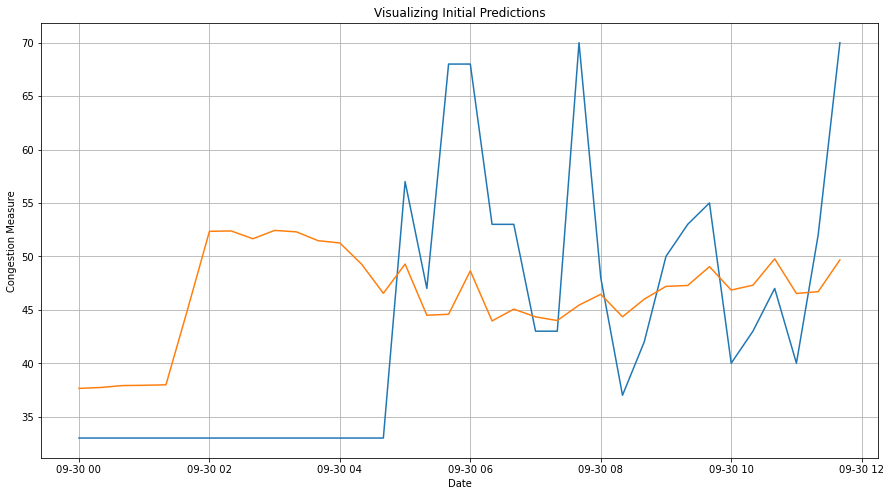

In [36]:
XGBoost_md = XGBoost_grid_search.best_estimator_

## Predicting on the test 
xgb_pred = XGBoost_md.predict(X_val)

## Computing the mse
print(mean_squared_error(Y_val, xgb_pred))

## Creating a new figure
plt.figure(figsize = (15, 8))

plt.plot(train_data_sample['time'][13023:13059], train_data_sample['congestion'][13023:13059])
plt.plot(train_data_sample['time'][13023:13059], xgb_pred)
plt.xlabel('Date')
plt.ylabel('Congestion Measure')
plt.title('Visualizing Initial Predictions')
plt.grid()
plt.show()

In [5]:
def main_XGB_all_directions(train, test):
    
    '''
    This function
    '''
    
    ## Defining all the directions
    directions = train['direction'].unique()
    
    ## Defining lists to store results
    results_all_directions_val = list()
    results_all_directions_test = list()
    
    for i in range(0, len(directions)):
        
        ## Subsetting train & test based on directions
        temp_train = train[train['direction'] == directions[i]].reset_index(drop = True)
        temp_test = test[test['direction'] == directions[i]].reset_index(drop = True)
        
        ## Appending results 
        results = main_XGB_all_directions_help(temp_train, temp_test)
        results_all_directions_val.append(results[0])
        results_all_directions_test.append(results[1])
            
    return [pd.concat(results_all_directions_val), pd.concat(results_all_directions_test)]
        
        
def main_XGB_all_directions_help(train, test):
    
    ## Defining lists to store results
    results_all_locations_val = list()
    results_all_locations_test = list()
    
    ## Defining locations 
    x_values = train['x'].unique()
    y_values = train['y'].unique()
    
    ## Defining list to store results
    results_all_locations = list()
    
    for i in range(0, len(x_values)):
        
        for j in range(0, len(y_values)):
            
            ## Subsetting train & test based on locaitons
            temp_train = train[(train['x'] == x_values[i]) & (train['y'] == y_values[j])].reset_index(drop = True)
            temp_test = test[(test['x'] == x_values[i]) & (test['y'] == y_values[j])].reset_index(drop = True)
            
            ## Modeling building and prediction at location (x, y)
            results = main_XGB_all_directions_help_help(temp_train, temp_test)
            results_all_locations_val.append(results[0])
            results_all_locations_test.append(results[1])
            
    return [pd.concat(results_all_locations_val), pd.concat(results_all_locations_test)]
            

def main_XGB_all_directions_help_help(train, test):            
    
    ## Defining train, validation, and test datasets
    X_train = train.loc[0:13023, ['day', 'hour', 'minute']]
    Y_train = train.loc[0:13023, ['congestion']]

    X_val = train.loc[13023:13059, ['day', 'hour', 'minute']]
    Y_val = train.loc[13023:13059, ['congestion']]
    
    X_test = test[['day', 'hour', 'minute']]
    
    ## Defining the hyper-parameter grid
    XGBoost_param_grid = {'n_estimators': [300],
                          'max_depth': [5, 7],
                          'min_child_weight': [5, 7, 10],
                          'learning_rate': [0.01],
                          'gamma': [0.3, 0.1],
                          'subsample': [0.8, 1],
                          'colsample_bytree': [1]}

    ## Performing grid search with 5 folds
    XGBoost_grid_search = GridSearchCV(XGBRegressor(), XGBoost_param_grid, cv = 5, scoring = 'neg_mean_absolute_error').fit(X_train, Y_train)

    ## Extracting the best model
    XGBoost_md = XGBoost_grid_search.best_estimator_

    ## Predicting on validation & test 
    XGBoost_val_pred = XGBoost_md.predict(X_val)
    XGBoost_test_pred = XGBoost_md.predict(X_test)
    
    ## Appending predictions on validation and test
    data_out = train.loc[13023:13059].reset_index(drop = True)
    data_out['congestion_pred'] = XGBoost_val_pred
    test['congestion_pred'] = XGBoost_test_pred
    
#     return data_out
    return [data_out[['row_id', 'time', 'x', 'y', 'direction', 'congestion', 'congestion_pred']], test[['row_id', 'time', 'x', 'y', 'direction', 'congestion_pred']]]

In [3]:
# A = train[(train['direction'] == 'EB') & (train['x'] == 0) & (train['y'] == 0)].reset_index(drop = True)
# B = test[(test['direction'] == 'EB') & (test['x'] == 0) & (test['y'] == 0)].reset_index(drop = True)

A = train[(train['direction'] == 'EB') & (train['x'] == 0) & (np.isin(train['y'], [0, 1]))]
B = test[(test['direction'] == 'EB') & (test['x'] == 0) & (np.isin(test['y'], [0, 1]))]

out = main_XGB_all_directions(A, B)